#Apply Lipstick

In this notebook you will find a fast and easy method to apply different colors lipsticks to your pictures using only Opencv and Dlib with Python. It's important to know that this notebook only works with pictures that have only 1 face or it will apply lipstick only to the first face that is detected.

### Step 1

First we need to import the packages: dlib, opencv (cv2) and numpy. You'll need numpy to work with matrixes.

If you don't have installed yet you can install them with pip, using the commands:
```
pip install opencv-python
pip install dlib
pip install numpy
```


In [1]:
import dlib
import cv2
import numpy as np

Also you'll want to install matplotlib to see the images on this notebook, so if you don't have installed you can install it with:
```
pip install matplotlib
```

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib
matplotlib.rcParams['figure.figsize'] = (15.0,15.0)
matplotlib.rcParams['image.cmap'] = 'gray'

## Step 2

Here we need to initialize the face detector and the landmarks detector, these detectors will let us to find and extract the lips of one face so later we can modify the color and apply the one that we want.

To initialize the landmarks detector we need the configuration file, in this case we want the one with 68 points. We can find the file [here](http://dlib.net/files/).

Text(0.5, 1.0, 'IM')

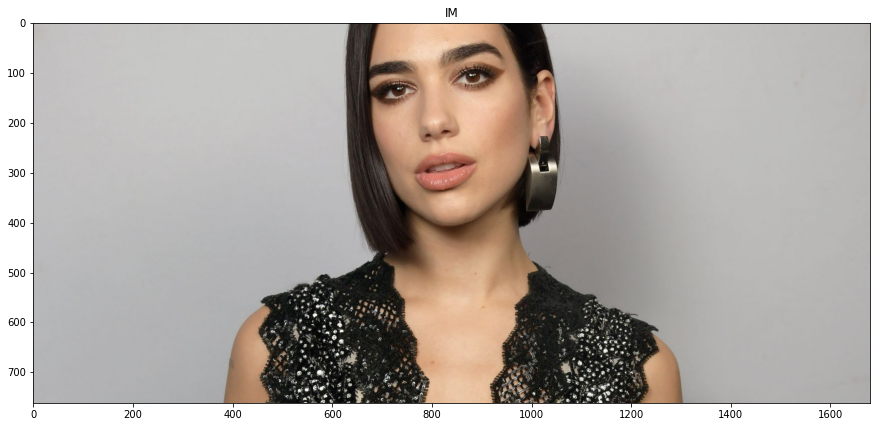

In [3]:
# Get the face detector instance
faceDetector = dlib.get_frontal_face_detector()

# The landmark detector is implemented in the shape_predictor class
landmarkDetector = dlib.shape_predictor("./shape_predictor_68_face_landmarks.dat")

# Read image
im= cv2.imread("./dua.jpg")

plt.imshow(im[:,:,::-1])
plt.title("IM")

Then we need to detect faces by passing the image to the face detector. The 0 signifies that no upscaling is done, so we could lose some small faces but we don't care it in this case.

In [4]:
# Detect faces in the image
faceRects = faceDetector(im, 0)
print("Number of faces detected: ",len(faceRects))

# List to store landmarks of all detected faces
landmarksAll = []

Number of faces detected:  1


## Functions

We define the function getPoints to obtain the coordinates of the interests points according to the result of the landmark detector. So we need to pass as arguments: all the landmarks and the initial and final point, finally the function return us the coordinates of the points.

In [5]:
def getPoints(landmarks, start, end):
  points = []
  for i in range(start, end+1):
    point = [landmarks.part(i).x, landmarks.part(i).y]
    points.append(point)

  return np.array(points, dtype=np.int32)

Here we define the function lipsMask that returns us the mask of the lips by pasing as argument the original image and all the landmarks that we obtain from the Dlib's landmarks detector. Then inside the function we use the function mentioned above to get the points of outer lips (48-59) and inner lips (60-67). Finally we create a convex polygon of the lips first filling the polygon of the outer lips with ones and the polygon of the inner lips with zeros.

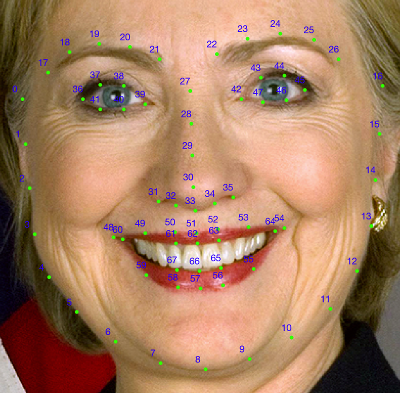

In [6]:
def lipsMask(im, landmarks): 
  mask = np.zeros((im.shape[0], im.shape[1]))
  
  outerLip = getPoints(landmarks, 48, 59)
  innerLip = getPoints(landmarks, 60, 67)

  cv2.fillConvexPoly(mask, outerLip, 1)
  cv2.fillConvexPoly(mask, innerLip, 0)

  return mask.astype(np.bool)

The function processLipsMask is responsible for "clean" our mask by removing areas that aren't belong to lips. To do this we use the morphological operations, first we do a CLOSE operation to remove the black holes of the mask, after that we do an OPEN operation to remove some white holes that could are out of the desired mask, then we do an ERODE operation to eliminate possible regions of the face that are not the lips and finally we do a Gaussian Blur to make the mask smoother. This time we need to pass as arguments the original image and the mask obtained with the previous function.

In [7]:
def processLipsMask(im, mask):
  kernelSize = 2
  element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*kernelSize+1, 2*kernelSize+1),(kernelSize, kernelSize))

  oMask = mask.astype(np.uint8)
  oMask = cv2.morphologyEx(oMask, cv2.MORPH_CLOSE, element, iterations=1)
  oMask = cv2.morphologyEx(oMask, cv2.MORPH_OPEN, element, iterations=1)

  kernelSize = 1
  element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*kernelSize+1, 2*kernelSize+1),(kernelSize, kernelSize))
  oMask = cv2.erode(oMask, element)
  oMask = cv2.GaussianBlur(oMask.astype(np.float), (3,3), 0)

  lipsNew = np.zeros_like(im)
  lipsNew[oMask.astype(np.bool)] = im[oMask.astype(np.bool)]

  return lipsNew, oMask

To apply the lipstick color we define the function applyLipstickColor, this receive as argument the Hue and Saturation value (corresponding to the HLS color space) of the color we want to apply and the image only of the lips. The algorithm implemented here is prety easy. First we convert the image of the lips to the HLS color space. Second we calculate the mean of the color pixels to know how much we have to add or substract to obtain our desired color, then we calculate this amount by substracting the mean obtained to the desired value.Finally we add this amount to all the color pixels so this way we obtain the lips with the color desired.

In [8]:
def applyLipstickColor(lipsNew, hue=20, saturation=0.6):
  lipsHSL = cv2.cvtColor(lipsNew, cv2.COLOR_BGR2HLS)

  H = lipsHSL[:,:,0]
  Hmean = lipsHSL[:,:,0]
  # We need the mean only of the color pixels without the black region
  Hmean = np.where(Hmean == 0, np.nan, Hmean)
  Hmean = np.nanmean(Hmean)
  h = hue/2 - Hmean

  H1 = np.where(H + h < 0, 180 + (H + h), np.where(H + h > 180, (H + h) - 180, H + h))
  lipsHSL[:,:,0] = H1

  S = lipsHSL[:,:,2]
  Smean = lipsHSL[:,:,2]
  # We need the mean only of the color pixels without the black region
  Smean = np.where(Smean == 0, np.nan, Smean)
  Smean = np.nanmean(Smean)
  s = saturation*255 - Smean

  S1 = np.where(S + s < 0, 0, np.where(S + s > 255, 255, S + s))
  lipsHSL[:,:,2] = S1

  return cv2.cvtColor(lipsHSL, cv2.COLOR_HLS2BGR)

The last function that we define is responsible for merge our image of the lips with lipstick with the original image, so this way we obtain our final result of applying lipstick. Here we only do the Alpha Blending process.



> Alpha blending is the process of overlaying a foreground image with transparency over a background image. The transparency is often the fourth channel of an image ( e.g. in a transparent PNG), but it can also be a separate image. This transparency mask is often called the alpha mask or the alpha matte.

> The math behind alpha blending is straightforward. At every pixel of the image, we need to combine the foreground image color (F) and the background image color (B) using the alpha mask (⍺).
Note: The value of ⍺ used in the equation is actually the pixel value in the alpha mask divided by 255. So, the final alpha blended image(I) is given by the equation below, 0≤ ⍺ ≤ 1

> I=αF+(1−α)B

> From the equation above, one can make the following observations.
- When α = 0, the output pixel color is the background.
- When α = 1, the output pixel color is simply the foreground.
- When 0≤α≤1, the output pixel color is a mix of the background and the foreground. For realistic blending, the boundary of the alpha mask usually has pixels that are between 0 and 1.

> *Extract of OpenCV course lesson*



In [9]:
def alphaBlend(mask, im, newColor):
  alphaMask = mask
  alpha = cv2.merge((alphaMask,alphaMask,alphaMask))
  alpha = np.where(alpha > 0, 1.0, 0.0)

  # Perform alpha blending
  foreground = cv2.multiply(alpha, newColor.astype(np.float))
  background = cv2.multiply(1.0 - alpha, im.astype(np.float))
  return cv2.add(foreground, background)

# Step 3

Once we have the faces the Dlib's face detector returned (this case is only one), we create a dlib's rectangle with the coordenates of the face detected and then pass this rectangle with the image to the landmarks detector.

In [10]:
newRect = dlib.rectangle(int(faceRects[0].left()),
                        int(faceRects[0].top()),
                        int(faceRects[0].right()),
                        int(faceRects[0].bottom()))
# For every face rectangle, run landmarkDetector
landmarks = landmarkDetector(im, newRect)
# Print number of landmarks
print("Number of landmarks",len(landmarks.parts()))

# Store landmarks for current face
landmarksAll.append(landmarks)

Number of landmarks 68


# Step 4

We use our lipsMask function to obtain the lips mask.

In [11]:
mask = lipsMask(im, landmarks)

# Step 5

Then we pass the mask obtained with the iamge to our processLipsMask function and we obtain our "clean" mask.

Text(0.5, 1.0, 'New mask')

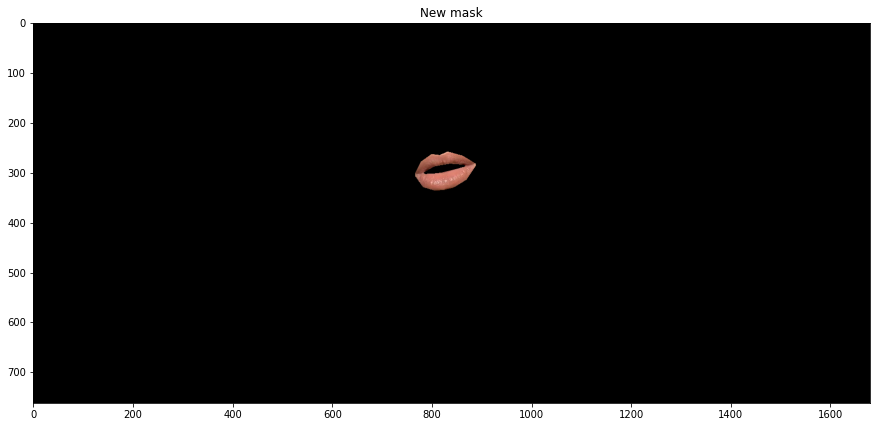

In [12]:
lipsNew, oMask = processLipsMask(im, mask)

plt.imshow(lipsNew[:,:,::-1])
plt.title("New mask")

# Step 6

We use our applyLipstickColor function to apply the desired color. To find the Hue and Saturation value we can use this [page](https://hslpicker.com).

In [13]:
redColor = applyLipstickColor(lipsNew, 360, 0.7)
orangeColor = applyLipstickColor(lipsNew, 30, 0.7)
purpleColor = applyLipstickColor(lipsNew, 280, 0.5)

# Step 7

Finally we do the alpha blending process to obtain our final result

In [14]:
redLips = alphaBlend(oMask, im, redColor)
orangeLips = alphaBlend(oMask, im, orangeColor)
purpleLips = alphaBlend(oMask, im, purpleColor)

# Step 8

And... we show our results

Text(0.5, 1.0, 'Purple Lips')

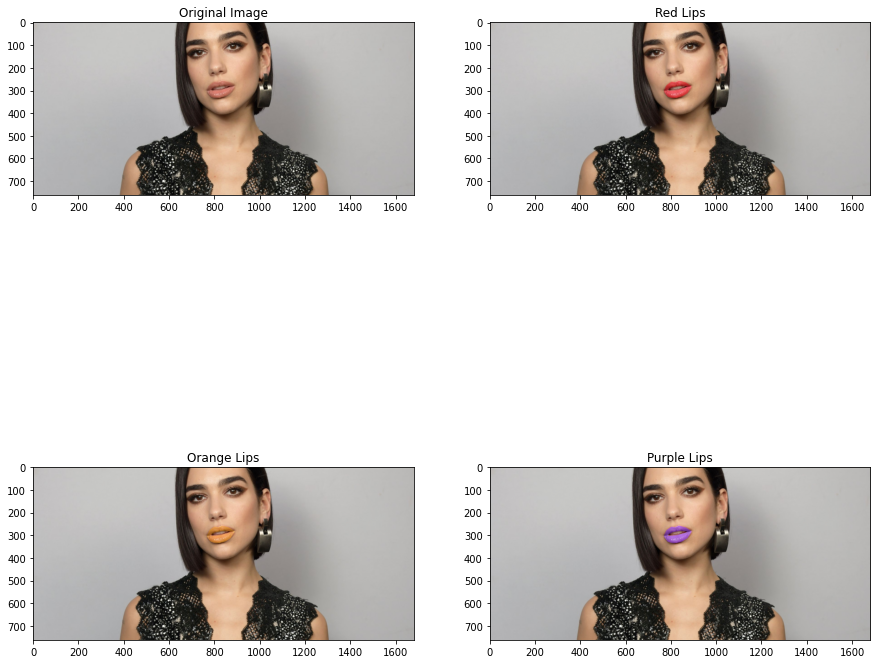

In [15]:
plt.subplot(2,2,1)
plt.imshow(im[:,:,::-1])
plt.title("Original Image")

plt.subplot(2,2,2)
plt.imshow(redLips[:,:,::-1]/255)
plt.title("Red Lips")

plt.subplot(2,2,3)
plt.imshow(orangeLips[:,:,::-1]/255)
plt.title("Orange Lips")
plt.subplot(2,2,4)

plt.imshow(purpleLips[:,:,::-1]/255)
plt.title("Purple Lips")